In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 77ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 192.3059 - mae: 192.8059
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/100
8/8 [==============================] - 0s 21ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 15ms/step - loss: 13.2242 - mae: 13.7148
Epoch 87/100
8/8 [==============================] - 0s 16ms/step - loss: 18.8805 - mae: 19.3730
Epoch 88/100
8/8 [==============================] - 0s 16ms/step - loss: 20.8682 - mae: 21.3656
Epoch 89/100
8/8 [==============================] - 0s 15ms/step - loss: 30.8087 - mae: 31.3076
Epoch 90/100
8/8 [==============================] - 0s 15ms/step - loss: 36.5054 - mae: 37.0032
Epoch 91/100
8/8 [==============================] - 0s 16ms/step - loss: 20.3312 - mae: 20.8246
Epoch 92/100
8/8 [==============================] - 0s 17ms/step - loss: 26.1809 - mae: 26.6784
Epoch 93/100
8/8 [==============================] - 0s 15ms/step - loss: 42.5046 - mae: 43.0038
Epoch 94/100
8/8 [==============================] - 0s 15ms/step - loss: 48.3925 - mae: 48.8925
Epoch 95/100
8/8 [==============================] - 0s 15ms/step - loss: 47.9951 - mae: 48.4942
Epoch 96/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

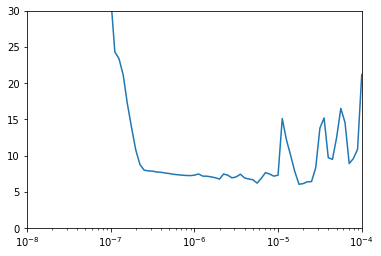

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 3s 21ms/step - loss: 114.4028 - mae: 114.9028
Epoch 2/400
8/8 [==============================] - 0s 20ms/step - loss: 22.2724 - mae: 22.7647
Epoch 3/400
8/8 [==============================] - 0s 19ms/step - loss: 17.3885 - mae: 17.8838
Epoch 4/400
8/8 [==============================] - 0s 18ms/step - loss: 13.2058 - mae: 13.7010
Epoch 5/400
8/8 [==============================] - 0s 18ms/step - loss: 9.7384 - mae: 10.2277
Epoch 6/400
8/8 [==============================] - 0s 18ms/step - loss: 15.2057 - mae: 15.7000
Epoch 7/400
8/8 [==============================] - 0s 18ms/step - loss: 14.1782 - mae: 14.6718
Epoch 8/400
8/8 [==============================] - 0s 19ms/step - loss: 10.0470 - mae: 10.5355
Epoch 9/400
8/8 [==============================] - 0s 19ms/step - loss: 7.6461 - mae: 8.1368
Epoch 10/400
8/8 [==============================] - 0s 19ms/step - loss: 9.8702 - mae: 10.3621
Epoch 11/400
8/8 [==============================] -

8/8 [==============================] - 0s 17ms/step - loss: 5.3734 - mae: 5.8538
Epoch 88/400
8/8 [==============================] - 0s 18ms/step - loss: 4.9330 - mae: 5.4130
Epoch 89/400
8/8 [==============================] - 0s 18ms/step - loss: 4.4321 - mae: 4.9069
Epoch 90/400
8/8 [==============================] - 0s 18ms/step - loss: 4.3856 - mae: 4.8580
Epoch 91/400
8/8 [==============================] - 0s 18ms/step - loss: 5.2763 - mae: 5.7527
Epoch 92/400
8/8 [==============================] - 0s 18ms/step - loss: 5.6722 - mae: 6.1579
Epoch 93/400
8/8 [==============================] - 0s 17ms/step - loss: 4.5142 - mae: 4.9929
Epoch 94/400
8/8 [==============================] - 0s 17ms/step - loss: 5.6971 - mae: 6.1698
Epoch 95/400
8/8 [==============================] - 0s 18ms/step - loss: 5.8191 - mae: 6.2978
Epoch 96/400
8/8 [==============================] - 0s 18ms/step - loss: 6.9958 - mae: 7.4864
Epoch 97/400
8/8 [==============================] - 0s 18ms/step - loss: 

8/8 [==============================] - 0s 18ms/step - loss: 5.7077 - mae: 6.1932
Epoch 174/400
8/8 [==============================] - 0s 18ms/step - loss: 5.1651 - mae: 5.6474
Epoch 175/400
8/8 [==============================] - 0s 19ms/step - loss: 4.4639 - mae: 4.9386
Epoch 176/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6440 - mae: 5.1195
Epoch 177/400
8/8 [==============================] - 0s 18ms/step - loss: 4.3323 - mae: 4.8078
Epoch 178/400
8/8 [==============================] - 0s 18ms/step - loss: 4.9221 - mae: 5.4032
Epoch 179/400
8/8 [==============================] - 0s 18ms/step - loss: 5.2989 - mae: 5.7792
Epoch 180/400
8/8 [==============================] - 0s 19ms/step - loss: 5.6126 - mae: 6.0963
Epoch 181/400
8/8 [==============================] - 0s 18ms/step - loss: 5.3106 - mae: 5.7912
Epoch 182/400
8/8 [==============================] - 0s 17ms/step - loss: 4.4170 - mae: 4.8911
Epoch 183/400
8/8 [==============================] - 0s 19ms/ste

8/8 [==============================] - 0s 18ms/step - loss: 4.0605 - mae: 4.5318
Epoch 260/400
8/8 [==============================] - 0s 17ms/step - loss: 4.4154 - mae: 4.8942
Epoch 261/400
8/8 [==============================] - 0s 17ms/step - loss: 5.1560 - mae: 5.6389
Epoch 262/400
8/8 [==============================] - 0s 18ms/step - loss: 4.1674 - mae: 4.6429
Epoch 263/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5248 - mae: 4.9994
Epoch 264/400
8/8 [==============================] - 0s 18ms/step - loss: 5.0344 - mae: 5.5192
Epoch 265/400
8/8 [==============================] - 0s 18ms/step - loss: 5.6638 - mae: 6.1442
Epoch 266/400
8/8 [==============================] - 0s 18ms/step - loss: 4.4829 - mae: 4.9648
Epoch 267/400
8/8 [==============================] - 0s 18ms/step - loss: 4.1985 - mae: 4.6715
Epoch 268/400
8/8 [==============================] - 0s 18ms/step - loss: 4.3479 - mae: 4.8218
Epoch 269/400
8/8 [==============================] - 0s 17ms/ste

8/8 [==============================] - 0s 18ms/step - loss: 5.0743 - mae: 5.5552
Epoch 346/400
8/8 [==============================] - 0s 18ms/step - loss: 4.2141 - mae: 4.6922
Epoch 347/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6093 - mae: 5.0886
Epoch 348/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8866 - mae: 5.3553
Epoch 349/400
8/8 [==============================] - 0s 17ms/step - loss: 4.5882 - mae: 5.0697
Epoch 350/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5278 - mae: 5.0036
Epoch 351/400
8/8 [==============================] - 0s 18ms/step - loss: 4.3025 - mae: 4.7782
Epoch 352/400
8/8 [==============================] - 0s 18ms/step - loss: 4.2842 - mae: 4.7565
Epoch 353/400
8/8 [==============================] - 0s 18ms/step - loss: 3.9762 - mae: 4.4507
Epoch 354/400
8/8 [==============================] - 0s 17ms/step - loss: 4.2989 - mae: 4.7728
Epoch 355/400
8/8 [==============================] - 0s 16ms/ste

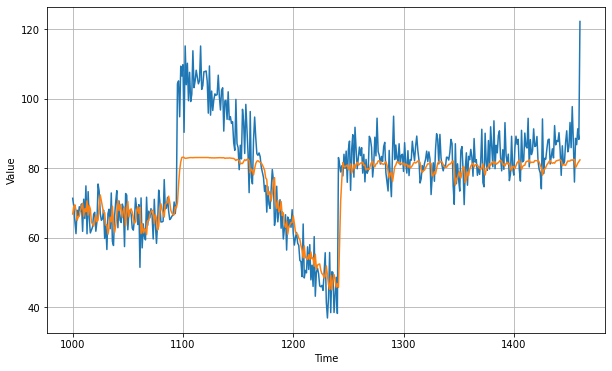

In [8]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.656944

<Figure size 432x288 with 0 Axes>

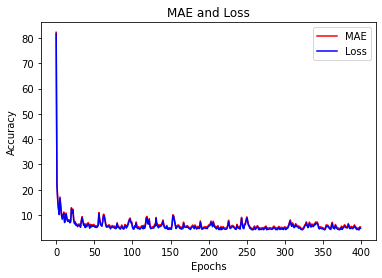

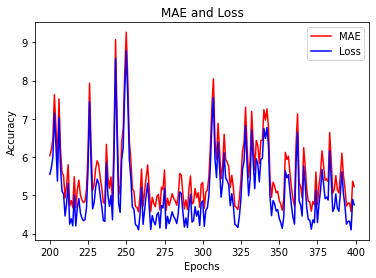

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# LSTM

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 16s 39ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 1s 34ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 1s 36ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 1s 34ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 1s 40ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 1s 35ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 1s 39ms/step - loss: 17.4906 - mae: 17.9840: 1s - loss: 18.0706 
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 16.8689 - mae: 17.3590
Epoch 1

31/31 [==============================] - 1s 37ms/step - loss: 6.2206 - mae: 6.7017
Epoch 85/100
31/31 [==============================] - 1s 35ms/step - loss: 7.8830 - mae: 8.3719
Epoch 86/100
31/31 [==============================] - 1s 37ms/step - loss: 11.4917 - mae: 11.9838
Epoch 87/100
31/31 [==============================] - 1s 36ms/step - loss: 7.2566 - mae: 7.7397
Epoch 88/100
31/31 [==============================] - 1s 35ms/step - loss: 6.0405 - mae: 6.5188
Epoch 89/100
31/31 [==============================] - 1s 33ms/step - loss: 7.7853 - mae: 8.2751
Epoch 90/100
31/31 [==============================] - 1s 41ms/step - loss: 6.7143 - mae: 7.1982
Epoch 91/100
31/31 [==============================] - 1s 42ms/step - loss: 8.4318 - mae: 8.9219
Epoch 92/100
31/31 [==============================] - 2s 44ms/step - loss: 8.9458 - mae: 9.4342
Epoch 93/100
31/31 [==============================] - 2s 52ms/step - loss: 8.3959 - mae: 8.8851: 0s - loss: 7.7081 -
Epoch 94/100
31/31 [==========

(1e-08, 0.0001, 0.0, 30.0)

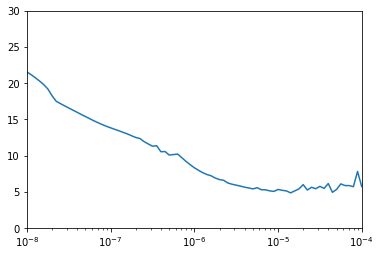

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

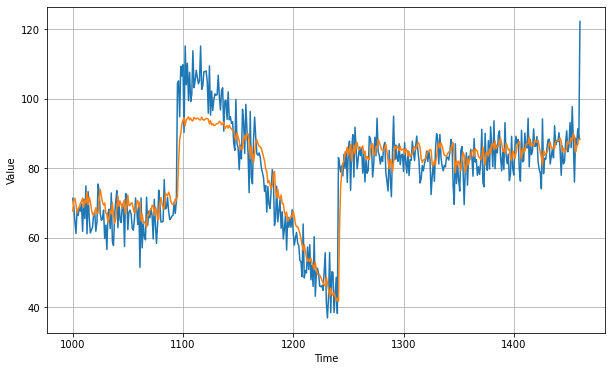

In [18]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5407486

<Figure size 432x288 with 0 Axes>

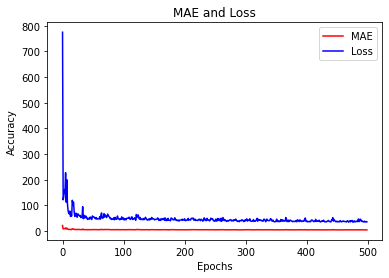

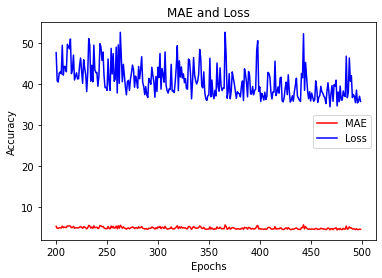

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [21]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [22]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 26s 46ms/step - loss: 1307.8963 1
Epoch 2/100
31/31 [==============================] - 2s 67ms/step - loss: 176.4447
Epoch 3/100
31/31 [==============================] - 1s 44ms/step - loss: 97.3890
Epoch 4/100
31/31 [==============================] - 1s 43ms/step - loss: 89.1422
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 79.4352
Epoch 6/100
31/31 [==============================] - 1s 43ms/step - loss: 81.9361
Epoch 7/100
31/31 [==============================] - 2s 44ms/step - loss: 71.1977
Epoch 8/100
31/31 [==============================] - 2s 50ms/step - loss: 80.9702
Epoch 9/100
31/31 [==============================] - 2s 47ms/step - loss: 72.1486 
Epoch 10/100
31/31 [==============================] - 2s 46ms/step - loss: 62.0152
Epoch 11/100
31/31 [==============================] - 2s 48ms/step - loss: 66.4223
Epoch 12/100
31/31 [==============================] - 2s 48ms/step - loss: 56.7716
Epoch 

31/31 [==============================] - 2s 48ms/step - loss: 43.6789
Epoch 100/100
31/31 [==============================] - 2s 45ms/step - loss: 42.8390


# LSTM with convolutions

In [23]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [25]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 18s 95ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 1s 97ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 1s 103ms/step - loss: 71.1748 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 1s 91ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 1s 99ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 1s 89ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 1s 89ms/step - loss: 62.0534 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 1s 85ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 1s 81ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [=============================

8/8 [==============================] - 1s 87ms/step - loss: 19.1859 - mae: 19.6810
Epoch 87/100
8/8 [==============================] - 1s 105ms/step - loss: 14.9050 - mae: 15.3976
Epoch 88/100
8/8 [==============================] - 1s 88ms/step - loss: 16.5458 - mae: 17.0416
Epoch 89/100
8/8 [==============================] - 1s 90ms/step - loss: 16.0321 - mae: 16.5257
Epoch 90/100
8/8 [==============================] - 1s 90ms/step - loss: 11.6083 - mae: 12.1015
Epoch 91/100
8/8 [==============================] - 1s 86ms/step - loss: 12.4502 - mae: 12.9406
Epoch 92/100
8/8 [==============================] - 1s 89ms/step - loss: 18.4850 - mae: 18.9785
Epoch 93/100
8/8 [==============================] - 1s 87ms/step - loss: 18.0093 - mae: 18.5049
Epoch 94/100
8/8 [==============================] - 1s 81ms/step - loss: 30.5584 - mae: 31.0547
Epoch 95/100
8/8 [==============================] - 1s 81ms/step - loss: 22.8282 - mae: 23.3248
Epoch 96/100
8/8 [==============================] - 

(1e-08, 0.0001, 0.0, 30.0)

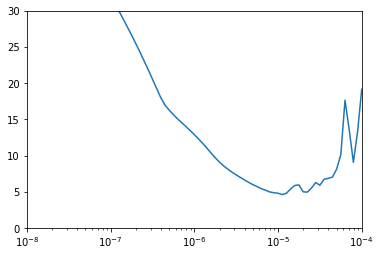

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 9s 37ms/step - loss: 33.5999 - mae: 34.0956
Epoch 2/500
31/31 [==============================] - 1s 33ms/step - loss: 8.4929 - mae: 8.9781
Epoch 3/500
31/31 [==============================] - 1s 35ms/step - loss: 6.9030 - mae: 7.3851
Epoch 4/500
31/31 [==============================] - 1s 37ms/step - loss: 6.3056 - mae: 6.7856
Epoch 5/500
31/31 [==============================] - 1s 38ms/step - loss: 5.7222 - mae: 6.2020
Epoch 6/500
31/31 [==============================] - 2s 42ms/step - loss: 5.7131 - mae: 6.1933
Epoch 7/500
31/31 [==============================] - 2s 43ms/step - loss: 5.5930 - mae: 6.0732
Epoch 8/500
31/31 [==============================] - 1s 42ms/step - loss: 5.3937 - mae: 5.8735
Epoch 9/500
31/31 [==============================] - 2s 41ms/step - loss: 5.3560 - mae: 5.8349
Epoch 10/500
31/31 [==============================] - 2s 46ms/step - loss: 5.3568 - mae: 5.8362
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 39ms/step - loss: 4.4681 - mae: 4.9448
Epoch 86/500
31/31 [==============================] - 2s 59ms/step - loss: 4.3026 - mae: 4.7775
Epoch 87/500
31/31 [==============================] - 2s 45ms/step - loss: 4.2990 - mae: 4.7738
Epoch 88/500
31/31 [==============================] - 1s 35ms/step - loss: 4.2758 - mae: 4.7507
Epoch 89/500
31/31 [==============================] - 1s 34ms/step - loss: 4.2316 - mae: 4.7062
Epoch 90/500
31/31 [==============================] - 1s 38ms/step - loss: 4.1874 - mae: 4.6621
Epoch 91/500
31/31 [==============================] - 1s 39ms/step - loss: 4.2523 - mae: 4.7264
Epoch 92/500
31/31 [==============================] - 1s 40ms/step - loss: 4.2184 - mae: 4.6918
Epoch 93/500
31/31 [==============================] - 1s 40ms/step - loss: 4.1535 - mae: 4.6273
Epoch 94/500
31/31 [==============================] - 2s 43ms/step - loss: 4.2745 - mae: 4.7495
Epoch 95/500
31/31 [==============================] -

31/31 [==============================] - 1s 41ms/step - loss: 4.1223 - mae: 4.5963
Epoch 168/500
31/31 [==============================] - 2s 42ms/step - loss: 4.1318 - mae: 4.6063
Epoch 169/500
31/31 [==============================] - 1s 40ms/step - loss: 4.1050 - mae: 4.5793
Epoch 170/500
31/31 [==============================] - 1s 41ms/step - loss: 4.3284 - mae: 4.8047
Epoch 171/500
31/31 [==============================] - 1s 39ms/step - loss: 4.1240 - mae: 4.5973
Epoch 172/500
31/31 [==============================] - 2s 42ms/step - loss: 4.1402 - mae: 4.6144
Epoch 173/500
31/31 [==============================] - 1s 39ms/step - loss: 4.1052 - mae: 4.5785
Epoch 174/500
31/31 [==============================] - ETA: 0s - loss: 4.1374 - mae: 4.611 - 2s 44ms/step - loss: 4.1364 - mae: 4.6099
Epoch 175/500
31/31 [==============================] - 1s 41ms/step - loss: 4.1881 - mae: 4.6629
Epoch 176/500
31/31 [==============================] - 2s 42ms/step - loss: 4.1106 - mae: 4.5842
Epoch 

31/31 [==============================] - 1s 37ms/step - loss: 4.1048 - mae: 4.5785
Epoch 251/500
31/31 [==============================] - 1s 39ms/step - loss: 4.1466 - mae: 4.6213
Epoch 252/500
31/31 [==============================] - 1s 37ms/step - loss: 4.0287 - mae: 4.5018
Epoch 253/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0613 - mae: 4.5342
Epoch 254/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0488 - mae: 4.5224
Epoch 255/500
31/31 [==============================] - 1s 38ms/step - loss: 4.1325 - mae: 4.6074
Epoch 256/500
31/31 [==============================] - 2s 49ms/step - loss: 4.0418 - mae: 4.5148
Epoch 257/500
31/31 [==============================] - 2s 56ms/step - loss: 4.0668 - mae: 4.5402
Epoch 258/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0769 - mae: 4.5507
Epoch 259/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0370 - mae: 4.5099
Epoch 260/500
31/31 [=======================

31/31 [==============================] - 1s 36ms/step - loss: 4.0222 - mae: 4.4939
Epoch 334/500
31/31 [==============================] - 1s 35ms/step - loss: 3.9705 - mae: 4.4412
Epoch 335/500
31/31 [==============================] - 1s 36ms/step - loss: 4.0848 - mae: 4.5594
Epoch 336/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0139 - mae: 4.4869
Epoch 337/500
31/31 [==============================] - 2s 44ms/step - loss: 4.0840 - mae: 4.5579
Epoch 338/500
31/31 [==============================] - 2s 42ms/step - loss: 3.9940 - mae: 4.4665
Epoch 339/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9798 - mae: 4.4520
Epoch 340/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9756 - mae: 4.4477
Epoch 341/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0866 - mae: 4.5609
Epoch 342/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0113 - mae: 4.4838
Epoch 343/500
31/31 [=======================

31/31 [==============================] - 1s 42ms/step - loss: 3.9756 - mae: 4.4485
Epoch 417/500
31/31 [==============================] - 1s 37ms/step - loss: 4.0283 - mae: 4.5012
Epoch 418/500
31/31 [==============================] - 1s 40ms/step - loss: 4.0171 - mae: 4.4906
Epoch 419/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9502 - mae: 4.4224
Epoch 420/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9428 - mae: 4.4146
Epoch 421/500
31/31 [==============================] - 1s 40ms/step - loss: 3.9609 - mae: 4.4325
Epoch 422/500
31/31 [==============================] - 1s 40ms/step - loss: 3.9265 - mae: 4.3992
Epoch 423/500
31/31 [==============================] - 1s 40ms/step - loss: 3.9368 - mae: 4.4074
Epoch 424/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9493 - mae: 4.4211
Epoch 425/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9846 - mae: 4.4575
Epoch 426/500
31/31 [=======================

Epoch 500/500
31/31 [==============================] - 1s 34ms/step - loss: 3.8982 - mae: 4.3698


In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

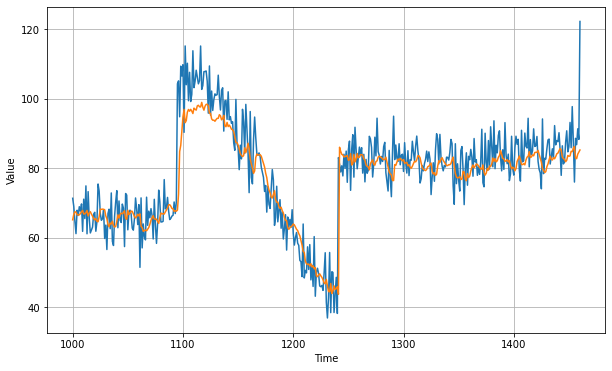

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.118608

<Figure size 432x288 with 0 Axes>

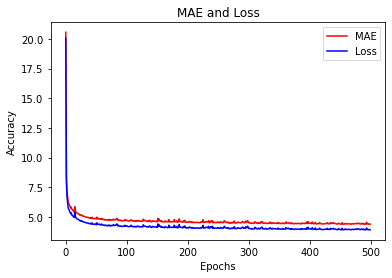

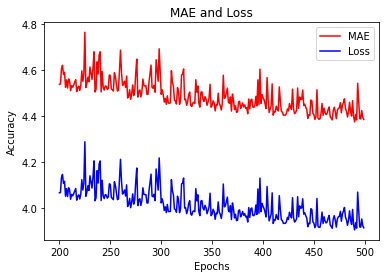

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()